In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.compat.v1 import placeholder
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn import preprocessing, model_selection

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [53]:
tf.compat.v1.disable_eager_execution()

## Data Visualization

In [3]:
data = pd.read_csv(f"/kaggle/input/stock-market-data/stock_market_data/sp500/csv/GOOG.csv")
data['Date'] = pd.to_datetime(  data['Date'], format='%d-%m-%Y' ) 

In [5]:
features = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']

In [6]:
scaler = preprocessing.MinMaxScaler()
train_size = int(data.shape[0] * .8)
train_data = data.loc[:train_size].copy()
test_data  = data.loc[train_size:].copy()

train_data.loc[:,features] = scaler.fit_transform(train_data[features])
test_data.loc[:,features] = scaler.transform(test_data[features])

In [7]:
data.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,4578.000000,4578.000000,4.578000e+03,4578.000000,4578.000000,4578.000000
mean,36.666628,37.042617,1.245911e+08,37.419654,37.049004,37.049004
std,34.570542,34.935752,1.539714e+08,35.314160,34.943732,34.943732
min,2.390042,2.470490,1.584340e+05,2.534002,2.490913,2.490913
25%,12.380159,12.517706,3.015650e+07,12.662662,12.525115,12.525115
50%,22.325443,22.472767,6.925662e+07,22.619093,22.504647,22.504647
75%,52.356688,52.904624,1.562575e+08,53.554625,52.976875,52.976875
max,149.887497,151.863495,1.650833e+09,152.100006,150.709000,150.709000


In [56]:
class StockData:
    features = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
    def __init__(self, data,timesteps, batch_size=32):
        self.df = data
        N, d = data.shape
        self.N = N
        self.d = d-1
        self.ts = timesteps
        self.batch_size=batch_size
        datas = []
        data = data[features].to_numpy()
        for idx in range(N-timesteps):
            datas.append(data[idx:idx+timesteps])
        self.data = np.array(datas)
        
    def sample(self):
        idx = np.random.randint(self.N)
        return data.loc[max(idx-self.ts,0):idx-1,features]
    
    def __iter__(self):
        return BatchIter(self, self.batch_size)
    
class BatchIter:
    def __init__(self, dataset, batch_size):
        self._data = dataset
        self.batch_size = batch_size
        self.idx = 0
        self.N = dataset.data.shape[0]
    def __next__(self):
        edx = self.idx+self.batch_size
        sdx = self.idx
        if edx >= self.N:
            sdx = self.N- self.batch_size-1
            edx = self.N-1
        if self.idx >= self.N:
            raise StopIteration
        
        X = self._data.data[sdx:edx,:-1,:]
        y = self._data.data[sdx:edx,-1,:]
        self.idx += self.batch_size
        return X,y

In [57]:
train_set = StockData(train_data, 20, batch_size=64)
test_set  = StockData(test_data, 20, batch_size=64)

In [66]:
x_train = []
y_train = []
x_test = []
y_test = []
for X,y in train_set:
    x_train.append(X)
    y_train.append(y)
    
for X,y in test_set:
    x_test.append(X)
    y_test.append(y)
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

In [61]:
X.shape

(64, 19, 6)

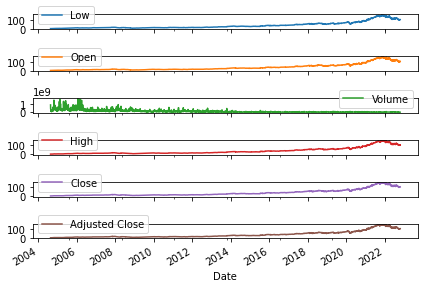

In [11]:
data.plot(subplots=True,x='Date')
plt.tight_layout()

## Part 1

In [45]:
X.shape

(3638, 19, 6)

In [72]:
model = keras.Sequential()

model.add(layers.Input(shape=(19,6),batch_size=batch_size))
model.add(layers.SimpleRNN(6))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6))
model.compile(loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(.0001))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (32, 6)                   78        
_________________________________________________________________
dense_16 (Dense)             (32, 64)                  448       
_________________________________________________________________
dense_17 (Dense)             (32, 6)                   390       
Total params: 916
Trainable params: 916
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
114/114 [==============================] - 2s 9ms/step - loss: 0.1508 - val_loss: 2.0321
Epoch 2/100
114/114 [==============================] - 1s 6ms/step - loss: 0.1019 - val_loss: 1.6532
Epoch 3/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0605 - val_loss: 1.3299
Epoch 4/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0315 - val_loss: 1.0499
Epoch 5/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0150 - val_loss: 0.8383
Epoch 6/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0071 - val_loss: 0.6908
Epoch 7/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.5998
Epoch 8/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.5468
Epoch 9/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.5078
Epoch 10/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0020 - val_lo

In [75]:
yhat = model.predict(x_test)

In [85]:
abs_error = np.abs(y_test - yhat).mean(axis=0)
(scaler.inverse_transform(y_test) - scaler.inverse_transform(yhat)).mean(axis=0)

array([0.37409592, 0.3430044 , 0.02448515, 0.38039393, 0.40675427,
       0.37909655])

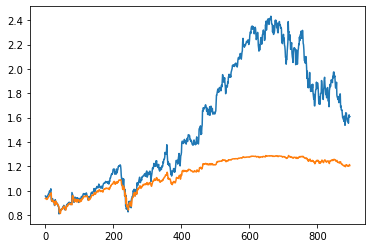

In [97]:
plt.plot(y_test[:,4])
plt.plot(yhat[:,4])

## Part 2

In [98]:
model2 = keras.Sequential()

model2.add(layers.Input(shape=(19,6),batch_size=batch_size))
model2.add(layers.LSTM(6,input_shape=(None,6)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(6))
model2.compile(loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(.0001))
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 6)                   312       
_________________________________________________________________
dense_18 (Dense)             (32, 64)                  448       
_________________________________________________________________
dense_19 (Dense)             (32, 6)                   390       
Total params: 1,150
Trainable params: 1,150
Non-trainable params: 0
_________________________________________________________________


In [103]:
model2.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
114/114 [==============================] - 2s 10ms/step - loss: 0.1129 - val_loss: 1.7123
Epoch 2/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0620 - val_loss: 1.2276
Epoch 3/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0211 - val_loss: 0.8808
Epoch 4/100
114/114 [==============================] - 1s 6ms/step - loss: 0.0075 - val_loss: 0.7297
Epoch 5/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.6469
Epoch 6/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.5954
Epoch 7/100
114/114 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.5600
Epoch 8/100
114/114 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.5336
Epoch 9/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.5133
Epoch 10/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0010 - val_l

In [104]:
yhat = model2.predict(x_test)
abs_error = np.abs(y_test - yhat).mean(axis=0)
(scaler.inverse_transform(y_test) - scaler.inverse_transform(yhat)).mean(axis=0)

array([2.21217728e+01, 2.22159862e+01, 2.07465924e+07, 2.03959532e+01,
       1.93915575e+01, 2.20380679e+01])

In [100]:
model2.predict(X).shape

(64, 6)

In [101]:
model3 = keras.Sequential()

model3.add(layers.Input(shape=(19,6),batch_size=batch_size))
model3.add(layers.GRU(6,input_shape=(None,6)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(6))
model3.compile(loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(.0001))
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (32, 6)                   252       
_________________________________________________________________
dense_20 (Dense)             (32, 64)                  448       
_________________________________________________________________
dense_21 (Dense)             (32, 6)                   390       
Total params: 1,090
Trainable params: 1,090
Non-trainable params: 0
_________________________________________________________________


In [102]:
model3.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
114/114 [==============================] - 3s 13ms/step - loss: 0.1051 - val_loss: 1.5203
Epoch 2/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0543 - val_loss: 1.0506
Epoch 3/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0244 - val_loss: 0.7514
Epoch 4/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0124 - val_loss: 0.5895
Epoch 5/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0072 - val_loss: 0.4914
Epoch 6/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.4271
Epoch 7/100
114/114 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.3836
Epoch 8/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.3543
Epoch 9/100
114/114 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.3373
Epoch 10/100
114/114 [==============================] - 1s 10ms/step - loss: 0.001

In [105]:
yhat = model3.predict(x_test)
abs_error = np.abs(y_test - yhat).mean(axis=0)
(scaler.inverse_transform(y_test) - scaler.inverse_transform(yhat)).mean(axis=0)

array([ 1.91287302e+01,  2.00867593e+01, -3.44980152e+07,  1.82618547e+01,
        2.00696671e+01,  1.86572117e+01])

The GRU model performs the best, followed by the LSTM, and the basic RNN worst. 

## Part 3

Yes. We can simply flatten our 2d matrix of features at each time step into a vector and pass this vector into a traditional neural net. We may also consider using a convolutional layer because of the heightened relationship between adjacent entries in the matrix. 